## MXS shiftの評価　2025.03.03
55Fe cal, uf dataにMXS phaseのフラグを追加

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from mxsgti import add_mxs_phase
os.chdir('/Volumes/SUNDISK_SSD/PKS_XRISM/mxs_shift_analysis')


In [2]:
infile = '/Volumes/SUNDISK_SSD/PKS_XRISM/000112000/resolve/event_uf/xa000112000rsl_p0px5000_uf.evt.gz'
outfile = './xa000112000rsl_p0px5000_uf_phase.evt'
timfile = '/Volumes/SUNDISK_SSD/PKS_XRISM/000112000/auxil/xa000112000.tim.gz'
hkfile = '/Volumes/SUNDISK_SSD/PKS_XRISM/000112000/resolve/hk/xa000112000rsl_a0.hk1'

add_mxs_phase(infile, outfile, hkfile, timfile)

   timestamp_led_on       timestamp_led_off  time_led_on  spc_ms  len_ms  i_set  i_set_ma  seq_num
2023-11-08 09:51:00 2023-11-08 10:25:49.375 1.531363e+08   93.75   0.625    314    1.0327        1
2023-11-08 10:56:00 2023-11-08 11:26:00.125 1.531402e+08   93.75   0.625    314    1.0327        2
2023-11-08 14:20:00 2023-11-08 14:37:00.125 1.531524e+08   93.75   0.625    314    1.0327        3
2023-11-08 17:38:00 2023-11-08 17:50:00.125 1.531643e+08   93.75   0.625    314    1.0327        4
2023-11-08 19:41:00 2023-11-08 20:10:00.125 1.531717e+08   93.75   0.625    314    1.0327        5
2023-11-08 20:57:00 2023-11-08 21:30:00.125 1.531762e+08   93.75   0.625    314    1.0327        6
2023-11-08 23:44:00 2023-11-08 23:54:25.375 1.531862e+08   93.75   0.625    314    1.0327        7
2023-11-09 00:07:00 2023-11-09 00:14:00.125 1.531876e+08   93.75   0.625    314    1.0327        8
2023-11-09 02:56:00 2023-11-09 03:26:00.125 1.531978e+08   93.75   0.625    314    1.0327        9
2023-11-09

(array([-1.        , -1.        , -1.        , ...,  0.23730311,
         0.14397246,  0.12426582], dtype='>f8'),
 array([1.53247671e+08, 1.53247671e+08, 1.53247671e+08, ...,
        1.53403198e+08, 1.53403198e+08, 1.53403198e+08], dtype='>f8'))

uf dataに追加したmxs phaseの確認

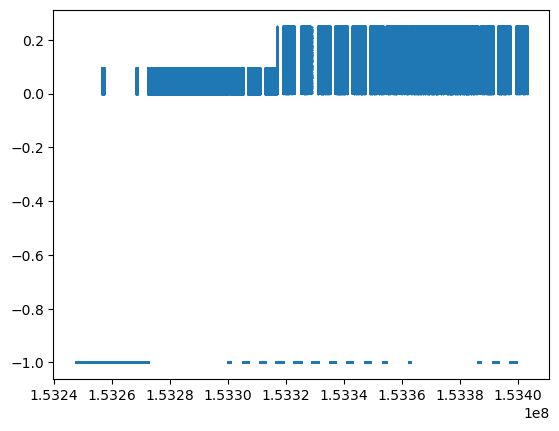

In [4]:
f = fits.open('xa000112000rsl_p0px5000_uf_phase.evt')['EVENTS'].data
phase = f['MXSPHASE']
time = f['TIME']
plt.scatter(time, phase, s=0.1)
plt.show()

phaseはちゃんとつけられてる。  
ftoolsでphase区切ったdataを出力できるようにする。
ftcopyでphase分けしたevent fileの作成

ftcopy infile="xa000112000rsl_p0px5000_uf_phase.evt[EVENTS][(MXSPHASE==-1||(MXSPHASE>10e-3))]" outfile=xa000112000rsl_p0px5000_uf_phase_10m.evt copyall=yes clobber=yes history=yes

ちゃんとphase分割されてるか確認

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


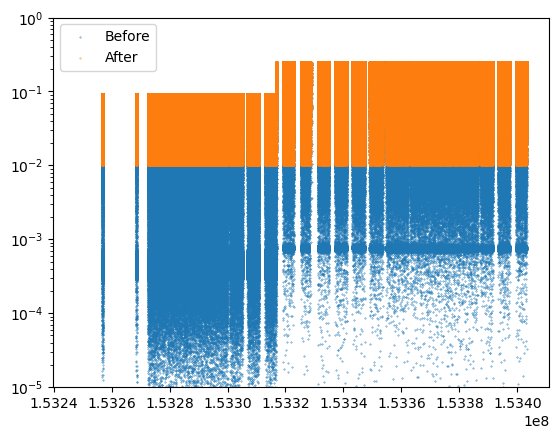

In [6]:
evt = fits.open('xa000112000rsl_p0px5000_uf_phase.evt')['EVENTS'].data
phase_before = evt['MXSPHASE']
time = evt['TIME']

evt2 = fits.open('xa000112000rsl_p0px5000_uf_phase_10m.evt')['EVENTS'].data
phase_after = evt2['MXSPHASE']
time2 = evt2['TIME']

plt.scatter(time, phase_before, s=0.1, label='Before')
plt.scatter(time2, phase_after, s=0.1, label='After')
plt.legend()
plt.ylim(1e-5, 1)
plt.yscale('log')
plt.show()

ちゃんと分割できている。  
次はrslgain実行してghfで違いがでるか確認する。

rslgain infile=xa000112000rsl_p0px5000_uf_phase.evt outfile=nom.ghf
rslgain infile=xa000112000rsl_p0px5000_uf_phase_10m.evt outfile=10m.ghf

ghfの比較

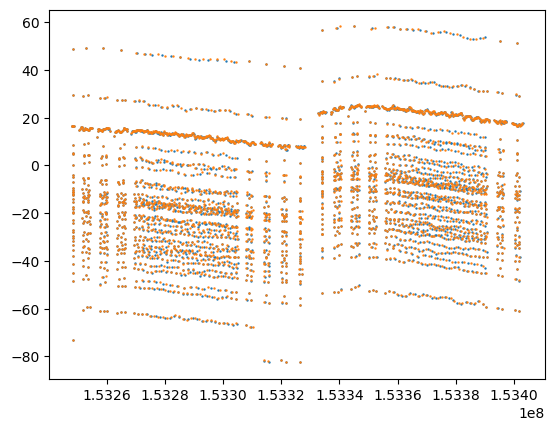

In [4]:
import matplotlib.pyplot as plt
from astropy.io import fits
f = fits.open('/Volumes/SUNDISK_SSD/PKS_XRISM/mxs_shift_analysis/repro_mxs_10ms/xa000112000rsl_000_fe55.ghf')[1].data
time_nom = f['TIME']
shift_nom = f['SHIFT']
pixel_nom = f['PIXEL']
plt.scatter(time_nom, shift_nom, s=0.5)
f = fits.open('xa000112000rsl_000_fe55.ghf.gz')[1].data
time_10m = f['TIME']
shift_10m = f['SHIFT']
pixel_10m = f['PIXEL']
plt.scatter(time_10m, shift_10m, s=0.5)
plt.show()

shiftで見ても違いがあまりわからない  
一番exposureの強い外側pixelで内挿直線の差を見てみる  
pixel 23, 21, 19, 9, 11


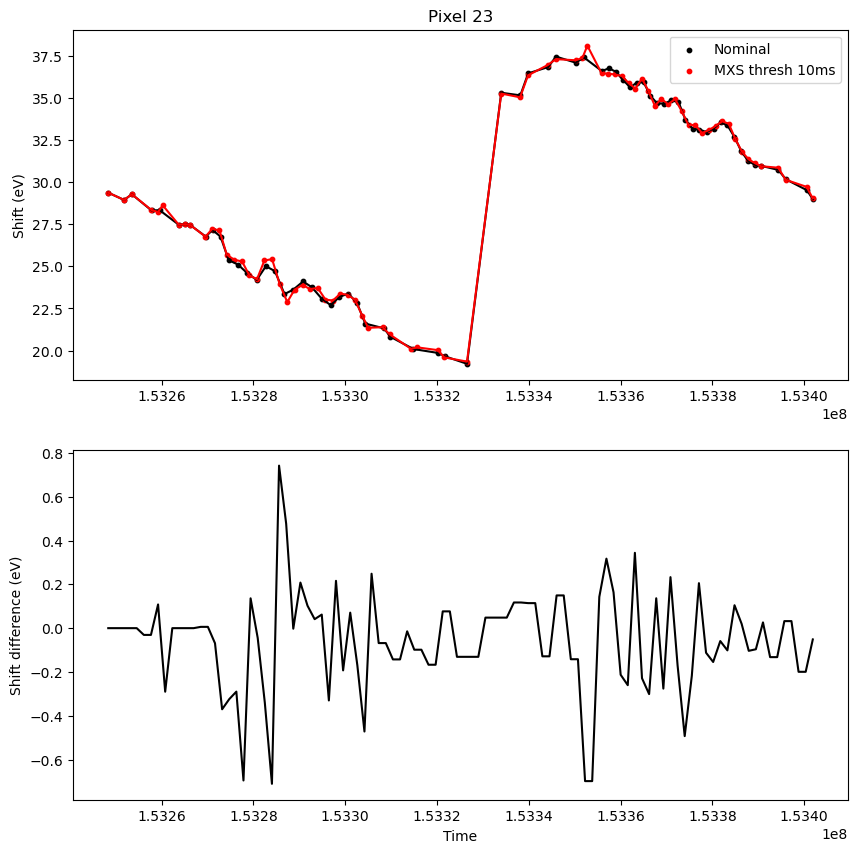

In [5]:
from scipy.interpolate import interp1d
method = 'nearest'
max_shifts = []
bright_shifts = []
pix_list = [23]
for pix in pix_list:
    nom_pix_mask = pixel_nom == pix
    nom_interp_shift = interp1d(time_nom[nom_pix_mask], shift_nom[nom_pix_mask], fill_value='extrapolate', kind=method)
    th_pix_mask = pixel_10m == pix
    th_interp_shift = interp1d(time_10m[th_pix_mask], shift_10m[th_pix_mask], fill_value='extrapolate', kind=method)
    dif_x = np.linspace(np.min(time_nom[nom_pix_mask]), np.max(time_nom[nom_pix_mask]), 100)
    dif_y = nom_interp_shift(dif_x) - th_interp_shift(dif_x)
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax[0].plot(time_nom[nom_pix_mask], shift_nom[nom_pix_mask], color='black')
    ax[0].scatter(time_nom[nom_pix_mask], shift_nom[nom_pix_mask], s=10, color='black', label='Nominal')
    ax[0].plot(time_10m[th_pix_mask], shift_10m[th_pix_mask], color='red')
    ax[0].scatter(time_10m[th_pix_mask], shift_10m[th_pix_mask], s=10, color='red', label='MXS thresh 10ms')
    ax[1].plot(dif_x, dif_y, color='black')
    max_shift    = np.nanmean(dif_y[dif_x<1.5332e8])
    bright_shift = np.nanmean(dif_y[dif_x>1.5334e8])
    max_shifts.append(max_shift)
    bright_shifts.append(bright_shift)
    ax[0].legend()
    ax[0].set_title(f'Pixel {pix}')
    ax[0].set_ylabel('Shift (eV)')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Shift difference (eV)')




plt.show()

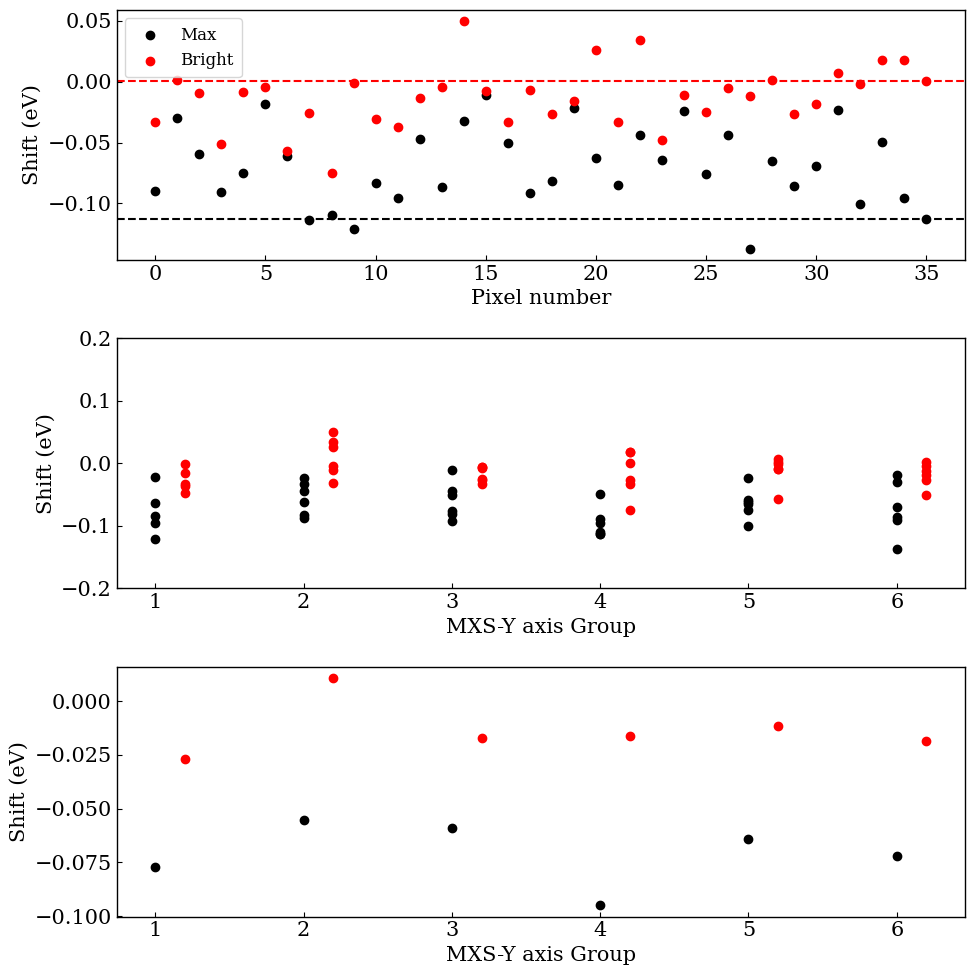

In [15]:
from scipy.interpolate import interp1d
from Dthesis_plot import DPlot
DPlot()
method = 'linear'
max_shifts = []
bright_shifts = []
pix_list = range(0,36)
for pix in pix_list:
    nom_pix_mask = pixel_nom == pix
    nom_interp_shift = interp1d(time_nom[nom_pix_mask], shift_nom[nom_pix_mask], fill_value='extrapolate', kind=method)
    th_pix_mask = pixel_10m == pix
    th_interp_shift = interp1d(time_10m[th_pix_mask], shift_10m[th_pix_mask], fill_value='extrapolate', kind=method)
    dif_x = np.linspace(np.min(time_nom[nom_pix_mask]), np.max(time_nom[nom_pix_mask]), 100)
    dif_y = nom_interp_shift(dif_x) - th_interp_shift(dif_x)
    # ax[0].plot(time_nom[nom_pix_mask], shift_nom[nom_pix_mask], color='black')
    # ax[0].scatter(time_nom[nom_pix_mask], shift_nom[nom_pix_mask], s=10, color='black', label='Nominal')
    # ax[0].plot(time_10m[th_pix_mask], shift_10m[th_pix_mask], color='red')
    # ax[0].scatter(time_10m[th_pix_mask], shift_10m[th_pix_mask], s=10, color='red', label='thresh=10ms')
    # ax[1].plot(dif_x, dif_y, color='black')
    max_shift = np.nanmean(dif_y[dif_x<1.5332e8])
    bright_shift = np.nanmean(dif_y[dif_x>1.5334e8])
    max_shifts.append(max_shift)
    bright_shifts.append(bright_shift)

fig, ax = plt.subplots(3, 1, figsize=(10, 10))
max_shifts = np.array(max_shifts)
bright_shifts = np.array(bright_shifts)
ax[0].scatter(pix_list, max_shifts, label='Max', color='black')
ax[0].axhline(np.mean(max_shift), color='black', linestyle='--')
ax[0].scatter(pix_list, bright_shifts, label='Bright', color='red')
ax[0].axhline(np.mean(bright_shift), color='red', linestyle='--')
ax[0].set_xlabel('Pixel number')
ax[0].set_ylabel('Shift (eV)')
ax[0].legend()
y1 = np.array([23,21,19,11,9])
y2 = np.array([24, 22, 20, 10, 13, 14])
y3 = np.array([25, 26, 18, 17, 15, 16])
y4 = np.array([0, 7, 8, 33, 34, 35])
y5 = np.array([2, 4, 6, 32, 31, 28])
y6 = np.array([30, 29, 1, 3, 5, 27])

off = 0.2
for i in y1:
    ax[1].scatter(1, max_shifts[i], color='black')
    ax[1].scatter(1+off, bright_shifts[i], color='red')
max_y1_avg = np.mean(max_shifts[y1])
bright_y1_avg = np.mean(bright_shifts[y1])
ax[2].scatter(1, max_y1_avg, color='black')
ax[2].scatter(1+off, bright_y1_avg, color='red')
for i in y2:
    ax[1].scatter(2, max_shifts[i], color='black')
    ax[1].scatter(2+off, bright_shifts[i], color='red')
max_y2_avg = np.mean(max_shifts[y2])
bright_y2_avg = np.mean(bright_shifts[y2])
ax[2].scatter(2, max_y2_avg, color='black')
ax[2].scatter(2+off, bright_y2_avg, color='red')
for i in y3:
    ax[1].scatter(3, max_shifts[i], color='black')
    ax[1].scatter(3+off, bright_shifts[i], color='red')
max_y3_avg = np.mean(max_shifts[y3])
bright_y3_avg = np.mean(bright_shifts[y3])
ax[2].scatter(3, max_y3_avg, color='black')
ax[2].scatter(3+off, bright_y3_avg, color='red')
for i in y4:
    ax[1].scatter(4, max_shifts[i], color='black')
    ax[1].scatter(4+off, bright_shifts[i], color='red')
max_y4_avg = np.mean(max_shifts[y4])
bright_y4_avg = np.mean(bright_shifts[y4])
ax[2].scatter(4, max_y4_avg, color='black')
ax[2].scatter(4+off, bright_y4_avg, color='red')
for i in y5:
    ax[1].scatter(5, max_shifts[i], color='black')
    ax[1].scatter(5+off, bright_shifts[i], color='red')
max_y5_avg = np.mean(max_shifts[y5])
bright_y5_avg = np.mean(bright_shifts[y5])
ax[2].scatter(5, max_y5_avg, color='black')
ax[2].scatter(5+off, bright_y5_avg, color='red')
for i in y6:
    ax[1].scatter(6, max_shifts[i], color='black')
    ax[1].scatter(6+off, bright_shifts[i], color='red')
ax[1].set_ylim(-0.2, 0.2)
max_y6_avg = np.mean(max_shifts[y6])
bright_y6_avg = np.mean(bright_shifts[y6])
ax[2].scatter(6, max_y6_avg, color='black')
ax[2].scatter(6+off, bright_y6_avg, color='red')
# sort_pix_max = np.argsort(max_shifts)
# ax[2].scatter(np.arange(36), max_shifts[sort_pix_max], label='Max', color='black')
# sort_pix_bright = np.argsort(bright_shifts)
# ax[2].scatter(np.arange(36), bright_shifts[sort_pix_bright], label='Bright', color='red')
# ax[2].axvline(np.arange(36), bright_shifts[sort_pix_bright], label='Bright', color='red')
# print(sort_pix_max)
ax[1].set_xlabel('MXS-Y axis Group')
ax[2].set_xlabel('MXS-Y axis Group')
ax[1].set_ylabel('Shift (eV)')
ax[2].set_ylabel('Shift (eV)')
fig.tight_layout()
fig.savefig('/Users/keitatanaka/Dropbox/figure_for_Dthesis/mxs_shifts_phase_10ms_55Fe.png', dpi=300)
plt.show()

そもそもnomで作ったghfとnasaが作ったghfが全然あっていなかった。  
filteringしてrslgainしないとだめらしい。以前55Feでreprocessかけたfileと元のghfはちゃんと一致していたのでxapipelineで処理して比較するようにする  
reprocessしてnasa dataと比較  
条件変えて比較




xapipeline indir=./000112000 outdir=./repro steminputs=xa000112000 stemoutputs=DEFAULT entry_stage=1 exit_stage=2 instrument=resolve verify_input=no create_ehkmkf=no calc_pointing=yes calc_optaxis=yes calc_gtilost=no calc_adrgti=no calc_mxsgti=no rsl_gainfile=CALDB calmethod=Fe55 linetocorrect=MnKa seed=650504 numevent=1000 minevent=200 extraspread=40 cleanup=yes clobber=yes

ghf比較すると完全に一致する。同様に5000_ufにmxsphaseで分割したfileを突っ込んでreprocessかけてghf比較する。calc_mxsgti=noにしないとerrorが発生してreprocessできなかった  
あとexit_stage=2だと結構時間かかるので1まででやる。MXSPHASEみたいな余計なcolumnがあるとgti mergeのところでエラーが発生する。ftcopyした後にMXSPHASEのcolumnを消すようにする。

xapipeline indir=../000112000 outdir=./ steminputs=xa000112000 stemoutputs=DEFAULT entry_stage=1 exit_stage=1 instrument=resolve verify_input=no create_ehkmkf=no calc_pointing=yes calc_optaxis=yes calc_gtilost=no calc_adrgti=no calc_mxsgti=no rsl_gainfile=CALDB calmethod=Fe55 linetocorrect=MnKa seed=650504 numevent=1000 minevent=200 extraspread=40 cleanup=yes clobber=yes